# DLCD itteration comparison tool 

In [1]:
'''
landcover classification legend

number 	landcover type 
0	no data
1	Extraction Sites
3	Inland Waterbodies
4	Salt Lakes
5	Irrigated Cropping
6	Irrigated Pasture
7	Irrigated Sugar
8	Rainfed Cropping
9	Rainfed Pasutre
10	Rainfed Sugar
11	Wetlands
14	Tussock Grasses - Closed
15	Alpine Grasses - Open
16	Hummock Grasses - Open
18	Tussock Grasses - Open
19	Shrubs and Grasses - Sparse-Scattered
24	Shrubs - Closed
25	Shrubs - Open
31	Trees - Closed
32	Trees - Open
33	Trees - Scattered
34	Trees - Sparse
35	Built up area '''


'\nlandcover classification legend\n\nnumber \tlandcover type \n0\tno data\n1\tExtraction Sites\n3\tInland Waterbodies\n4\tSalt Lakes\n5\tIrrigated Cropping\n6\tIrrigated Pasture\n7\tIrrigated Sugar\n8\tRainfed Cropping\n9\tRainfed Pasutre\n10\tRainfed Sugar\n11\tWetlands\n14\tTussock Grasses - Closed\n15\tAlpine Grasses - Open\n16\tHummock Grasses - Open\n18\tTussock Grasses - Open\n19\tShrubs and Grasses - Sparse-Scattered\n24\tShrubs - Closed\n25\tShrubs - Open\n31\tTrees - Closed\n32\tTrees - Open\n33\tTrees - Scattered\n34\tTrees - Sparse\n35\tBuilt up area '

In [2]:
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

#load requiered modules 
import numpy as np
import rasterio
#from matplotlib import pyplot as plt #don't need unless want to plot
import xarray as xr
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import os.path
from scipy import ndimage
from scipy.ndimage import measurements
from scipy import stats

import dask.array as da

#set up filepath due to folder re-arrangement 
os.chdir('/g/data/r78/ck9738')

dc = datacube.Datacube()


In [3]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

def load_gfif_full(file_name, x=1):


    dataset = rasterio.open(file_name) #open using Raterio
    {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
    data_array = dataset.read(x) #read selected band into np array
    data_xr = xr.DataArray(data_array) #turn into Xr array for fuctionality #Now don't need xr yet
    return(data_xr) #return np array into program 

In [4]:
#Temporal range and sensors of interest are defined

#set the number of chunks to pass to dask 
#(bigger chunks will run the dc_load faster, but be careful of hitting memory limits)
ds_chunks = 20

#extents
# extent_long = (145.293, 145.553) reference area??
# extent_lat = (-30.665, -30.404)

extent_long = (146.7, 148.)
extent_lat = (-31.5, -30.28)

#query is created
query = {}
query['x'] = extent_long
query['y'] = extent_lat
#query['crs'] = 'EPSG:3577'
#query['dask_chunks']= {'time' : ds_chunks} #divide query into chunks to save memory
    
print(query)

{'x': (146.7, 148.0), 'y': (-31.5, -30.28)}


In [5]:
import dask
dask.set_options(get=dask.get)

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [6]:
#import datacube
dc = datacube.Datacube()

dsm = dc.load(product='dsm1sv10', **query)


In [7]:
dsm.elevation

<xarray.DataArray 'elevation' (time: 1, latitude: 4393, longitude: 4681)>
array([[[129.8231 , 130.3859 , ..., 129.29071, 129.86147],
        [129.70604, 130.61859, ..., 128.88849, 129.71753],
        ...,
        [244.43295, 243.99184, ..., 194.4055 , 193.31433],
        [243.50734, 243.27754, ..., 194.06644, 193.62799]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-17T08:33:00
  * latitude   (latitude) float64 -30.28 -30.28 -30.28 -30.28 -30.28 -30.28 ...
  * longitude  (longitude) float64 146.7 146.7 146.7 146.7 146.7 146.7 146.7 ...
Attributes:
    nodata:   NaN
    units:    metre
    crs:      EPSG:4326

In [8]:
old_version = rasterfile_to_xarray("old_DLCD/DLCDv2_Comp_old.tif", dsm.geobox,
                                   num_bands=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), X_band=14)

new_version = rasterfile_to_xarray("new_DLCD/DLCDv2_2016_new.tif", dsm.geobox,
                                   num_bands=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15), X_band=14)

sim_new = np.array(new_version)
sim_old = np.array(old_version)

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [9]:
cmap = mpl.colors.ListedColormap(['xkcd:black',
'xkcd:grey',
'xkcd:black',
'xkcd:medium blue',
'xkcd:robin egg blue',
'xkcd:plum',
'xkcd:pink purple',
'xkcd:raspberry',
'xkcd:old pink',
'xkcd:pale pink',
'xkcd:warm pink',
'xkcd:tealish',
'xkcd:black',
'xkcd:black',
'xkcd:pumpkin orange',
'xkcd:white',
'xkcd:yellow',
'xkcd:black',
'xkcd:apricot',
'xkcd:eggshell',
'xkcd:black',
'xkcd:black',
'xkcd:black',
'xkcd:black',
'xkcd:umber',
'xkcd:tan',
'xkcd:black',
'xkcd:black',
'xkcd:black',
'xkcd:black',
'xkcd:black',
'xkcd:deep green', 
'xkcd:medium green',
'xkcd:light sage',
'xkcd:slime green',
'xkcd:light grey'])

#cmap = mpl.colors.ListedColormap(['xkcd:pale peach', 'xkcd:plum purple', 'xkcd:black', 'xkcd:grey', 'xkcd:medium blue'])
#cmap = mpl.colors.BoundaryNorm(vals, cmapo.N)                          

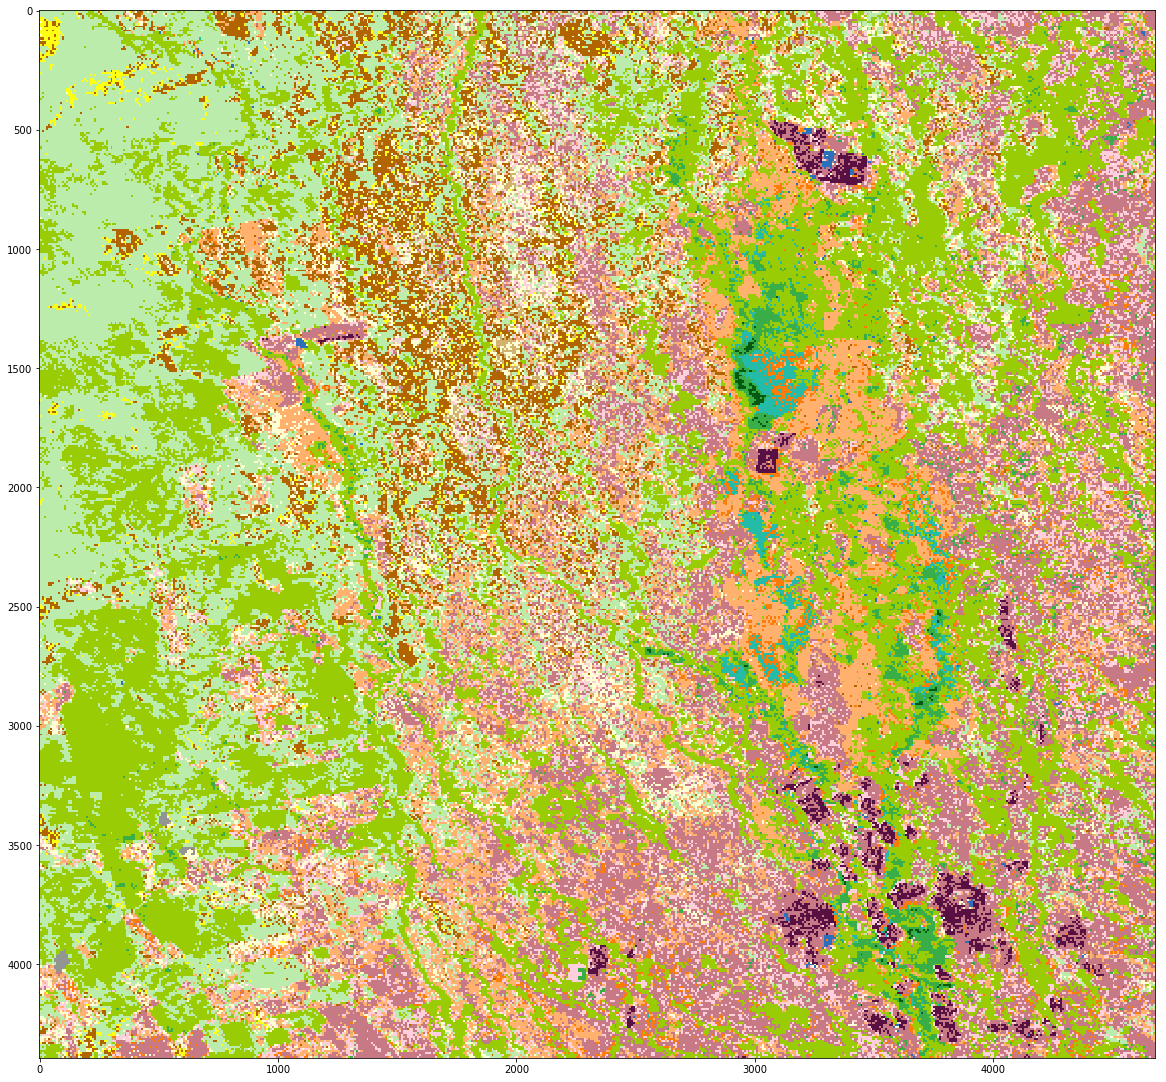

In [10]:
fig, ax = plt.subplots(figsize = (20,20))
cax = ax.imshow(new_version, cmap)
cax.set_clim(0, 35)
#plt.show()

In [11]:
# define function to return the number of pixles which are class A in old and class B in new:
#fuction returns an array, int: array with 1= occurance of class overlap and 0= everything else.

def count_overlap_array(old_np,A,new_np,B):
    raw_np = np.ones_like(old_np) #generate a np with the same size as the dlcd but full of 1 values
    raw_xr = xr.DataArray(raw_np) #turn to xarray for it's useful fuctionality
    count_old = raw_xr.where(old_np==A) # make an xr where 1= presance of class A, 0= absence 
    count_new = count_old.where(new_np==B) # make an xr where 1= overlap of classes A&B
    count_class = count_new.fillna(0) #replaces all the nan with 0
    howmuch_name = np.count_nonzero(count_class) #counts the number of non 0 in the xaray


    return(count_class) #returns an array

In [12]:
#this_change = count_overlap_array(sim_old, 3, sim_new, 11)

In [13]:
#this_change

looks like no change? 0
looks like no change? 0
153 this many pixles changed


/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


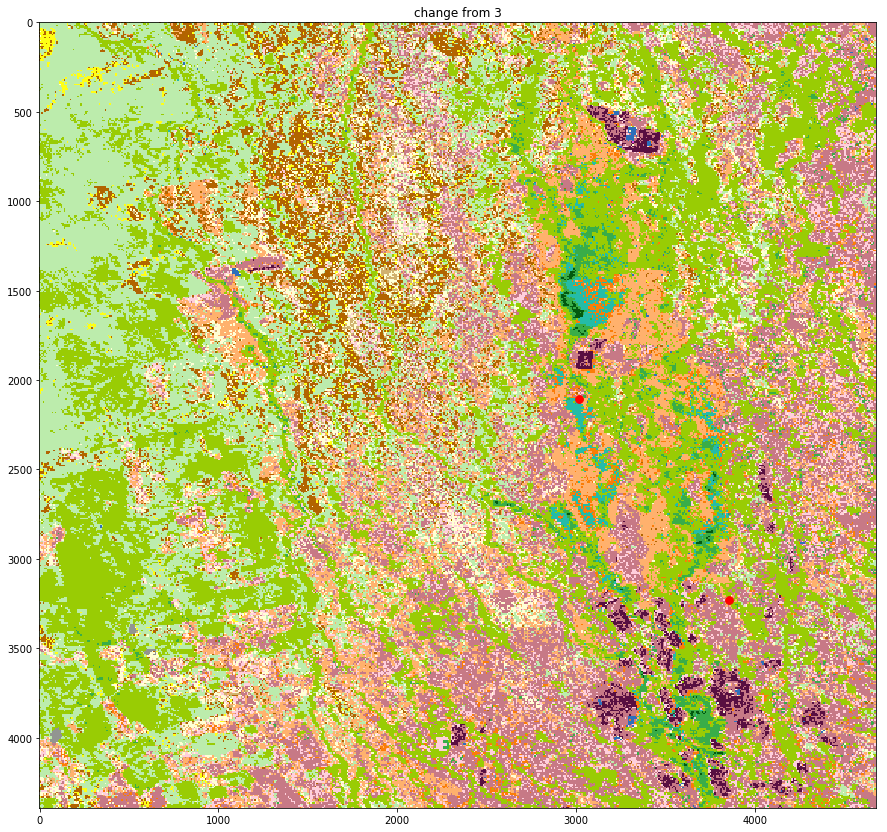

looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
613 this many pixles changed


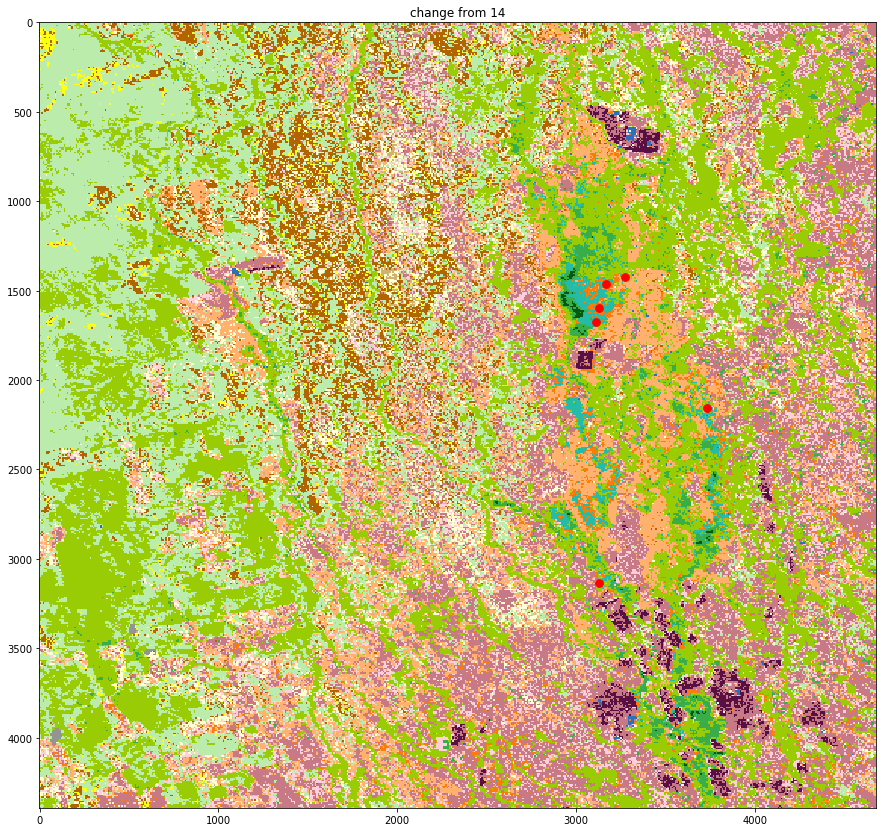

looks like no change? 0
looks like no change? 0
72 this many pixles changed


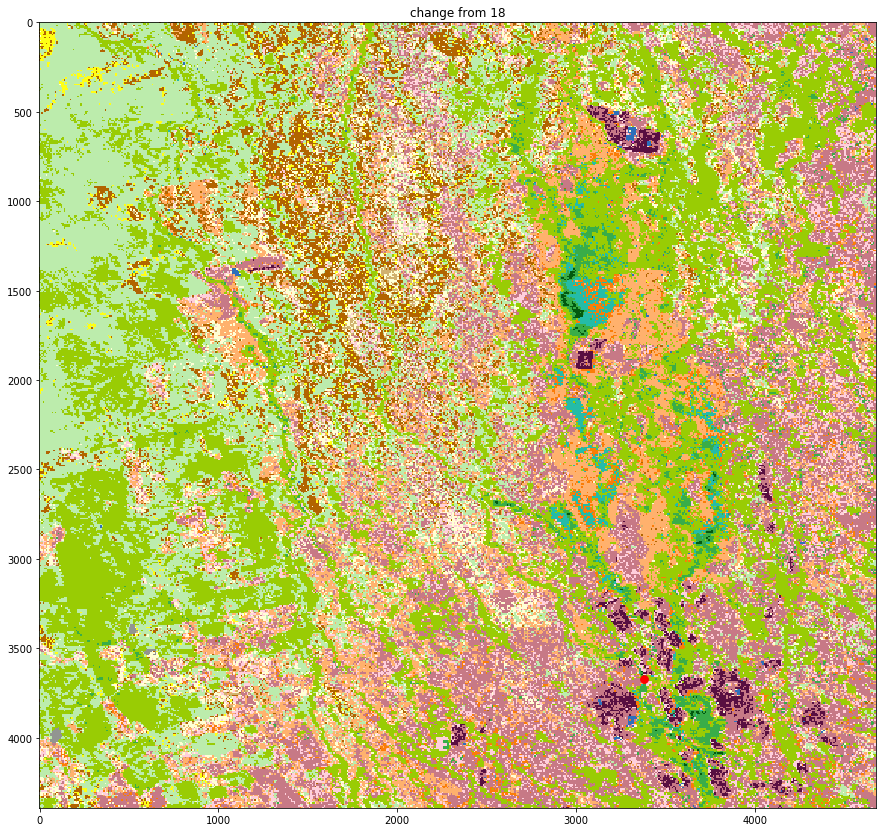

looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
looks like no change? 0
144 this many pixles changed


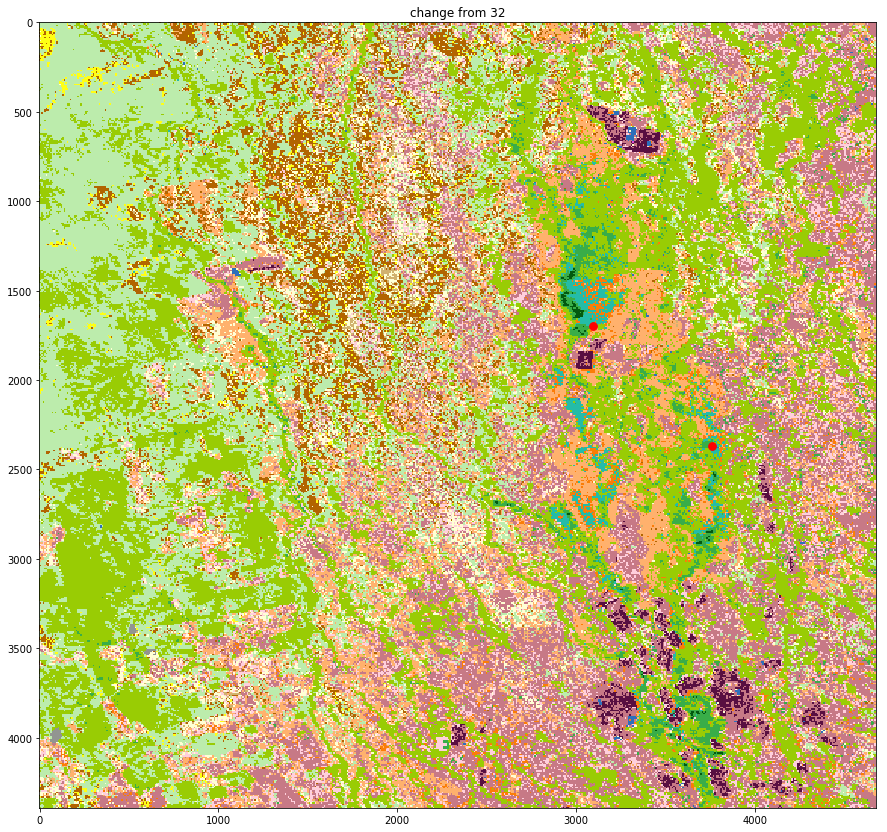

64 this many pixles changed


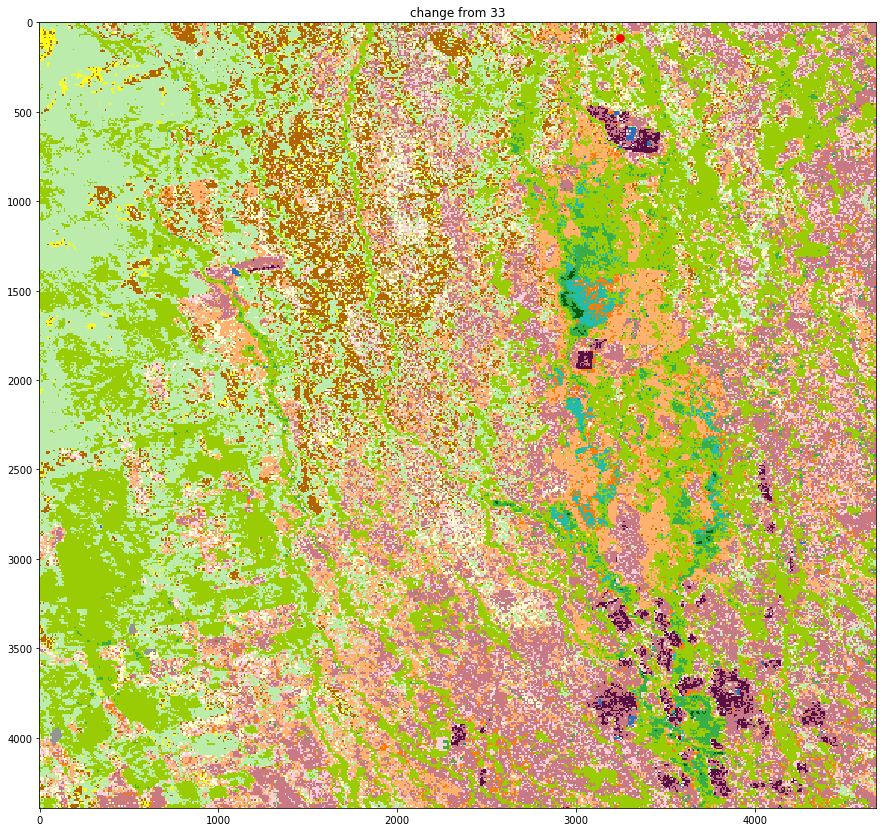

876 this many pixles changed


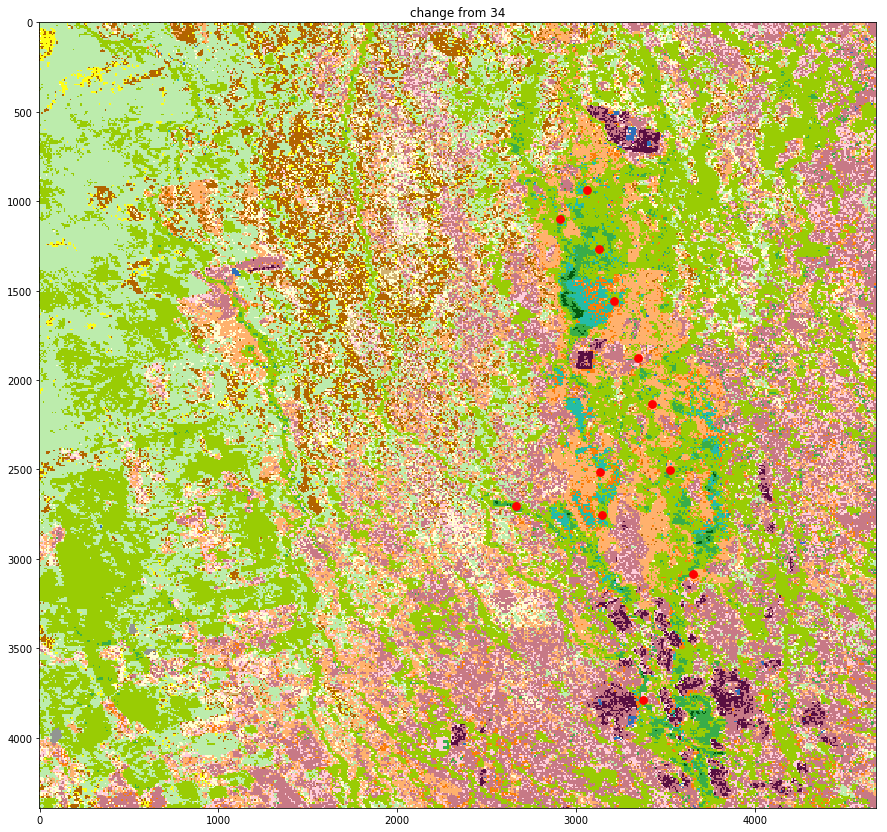

looks like no change? 0


In [14]:
#find class change loop !!

class_listing=[0,
1,
3,
4,
5,
6,
7,
8,
9,
10,
#11,
14,
15,
16,
18,
19,
22,
24,
25,
31,
32,
33,
34,
35]

for classes in class_listing:
    this_change = count_overlap_array(sim_old, 11, sim_new, classes)
    
    any_change = np.count_nonzero(this_change)
    
    if any_change >=1:
        print(any_change, 'this many pixles changed')
    
        labled_array, number_of_objects = measurements.label(this_change)
        name_point_list = np.unique(labled_array)
        list_of_points=measurements.center_of_mass(this_change,labled_array,name_point_list)
        output_list = [(b,a) for a,b in list_of_points]
    
    
        fig, ax = plt.subplots(figsize = (15,15))
        cax = ax.imshow(new_version, cmap)
        plt.title('change from '+str(classes))
        plt.scatter(*zip(*output_list),c='r', s=60)
        cax.set_clim(0, 35)
        plt.show()
    else:
        print('looks like no change?', any_change)

In [15]:
#Create output list of points where above specified class change has occured

labled_array, number_of_objects = measurements.label(this_change)
name_point_list = np.unique(labled_array)
list_of_points=measurements.center_of_mass(this_change,labled_array,name_point_list)
output_list = [(b,a) for a,b in list_of_points]

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/scipy/ndimage/measurements.py:1328: RuntimeWarning: invalid value encountered in true_divide
  for dir in range(input.ndim)]


In [16]:
output_list

[(nan, nan)]

In [17]:
fig, ax = plt.subplots(figsize = (15,15))
cax = ax.imshow(new_version, cmap)
plt.title('change from 'classes)
plt.scatter(*zip(*output_list),c='r', s=60)
cax.set_clim(0, 35)
plt.show()

SyntaxError: invalid syntax (<ipython-input-17-91e8c77b5e1a>, line 3)

In [ ]:
#define band list to loop through. these represen years
band_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

#create dicts to store pixledrill data into
New_DLCD_dit = dict()
Old_DLCD_dit = dict()

#count = 0 #defile count for counting the number of pixle drills conducted

#beging pixledrill loop
for i in band_list:
    count = 0 #defile count for counting the number of pixle drills conducted
    old_i_data = rasterfile_to_xarray("old_DLCD/DLCDv2_Comp_old.tif", dsm.geobox, num_bands=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14), X_band=i)
    new_i_data = rasterfile_to_xarray("new_DLCD/DLCDv2_2016_new.tif", dsm.geobox, num_bands=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15), X_band=i)
    if i < 10:
        year_i = '200'+str(i)
    else:
        year_i = '20'+str(i)

    New_mini_dit = dict() #make small yearly dicts to go into bigger one 
    Old_mini_dit = dict()

    for x,y in output_list:
        if x > 0:
            tup_x = int(x)
            tup_y = int(y)
                #set up stuff for file output nameing
            x_string = str(tup_x)
            y_string = str(tup_y)
            count = count+1
            #count_val = str(count)
            #name_val = 'point # '+count_val
            title_string = 'x= ' + x_string + ', y= '+ y_string

            #prepare ndwi7 vis light record for single point over epoc
            pd_new = new_i_data.isel(latitude=tup_y,longitude=tup_x)
            pd_old = old_i_data.isel(latitude=tup_y,longitude=tup_x)
            new_np = np.array(pd_new)
            old_np = np.array(pd_old)
            New_mini_dit[count] = new_np #add data for this point to mini yearly dict
            Old_mini_dit[count] = old_np

                    #new_np = np.array(pd_new)
                    #old_np = np.array(pd_old)

            New_DLCD_dit[year_i] = New_mini_dit #add year dicts to larger dicts 
            Old_DLCD_dit[year_i] = Old_mini_dit

In [ ]:
New_DLCD_dit

In [ ]:
new_years=[2001, 2002 ,2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
old_years=[2001, 2002 ,2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]

new_DLCD_panda = pd.DataFrame(New_DLCD_dit)
old_DLCD_panda = pd.DataFrame(Old_DLCD_dit)
new_DLCD_panda

In [ ]:
old_DLCD_panda